In [1]:
import requests
import pandas as pd
import os
import glob
from datetime import datetime
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import missingno as msno


# Data Preparation

### Load Data

In [2]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

# copy
df = clean_hdb_df1.copy()

### Exploratory Data Analysis

=== Data Quality Report ===

1. Basic Information:
Rows: 962,946
Columns: 23

2. Data Types:
remaining_lease                float64
floor_area_sqm                 float64
storey_range                    object
street_name                     object
lease_commence_date     datetime64[ns]
month                   datetime64[ns]
flat_type                       object
resale_price                   float64
town                            object
block                           object
flat_model                      object
storey_range_min                 int64
storey_range_max                 int64
full_address                    object
Latitude                       float64
Longitude                      float64
nearest_mrt_id                  object
mrt_name                        object
mrt_latitude                   float64
mrt_longitude                  float64
mrt_road                        object
Distance_from_MRT_km           float64
transaction_id                   int64
dtype: obj

/var/folders/y_/h86dm1h150v7bstq3mkcv4gm0000gn/T/ipykernel_5464/2745395831.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

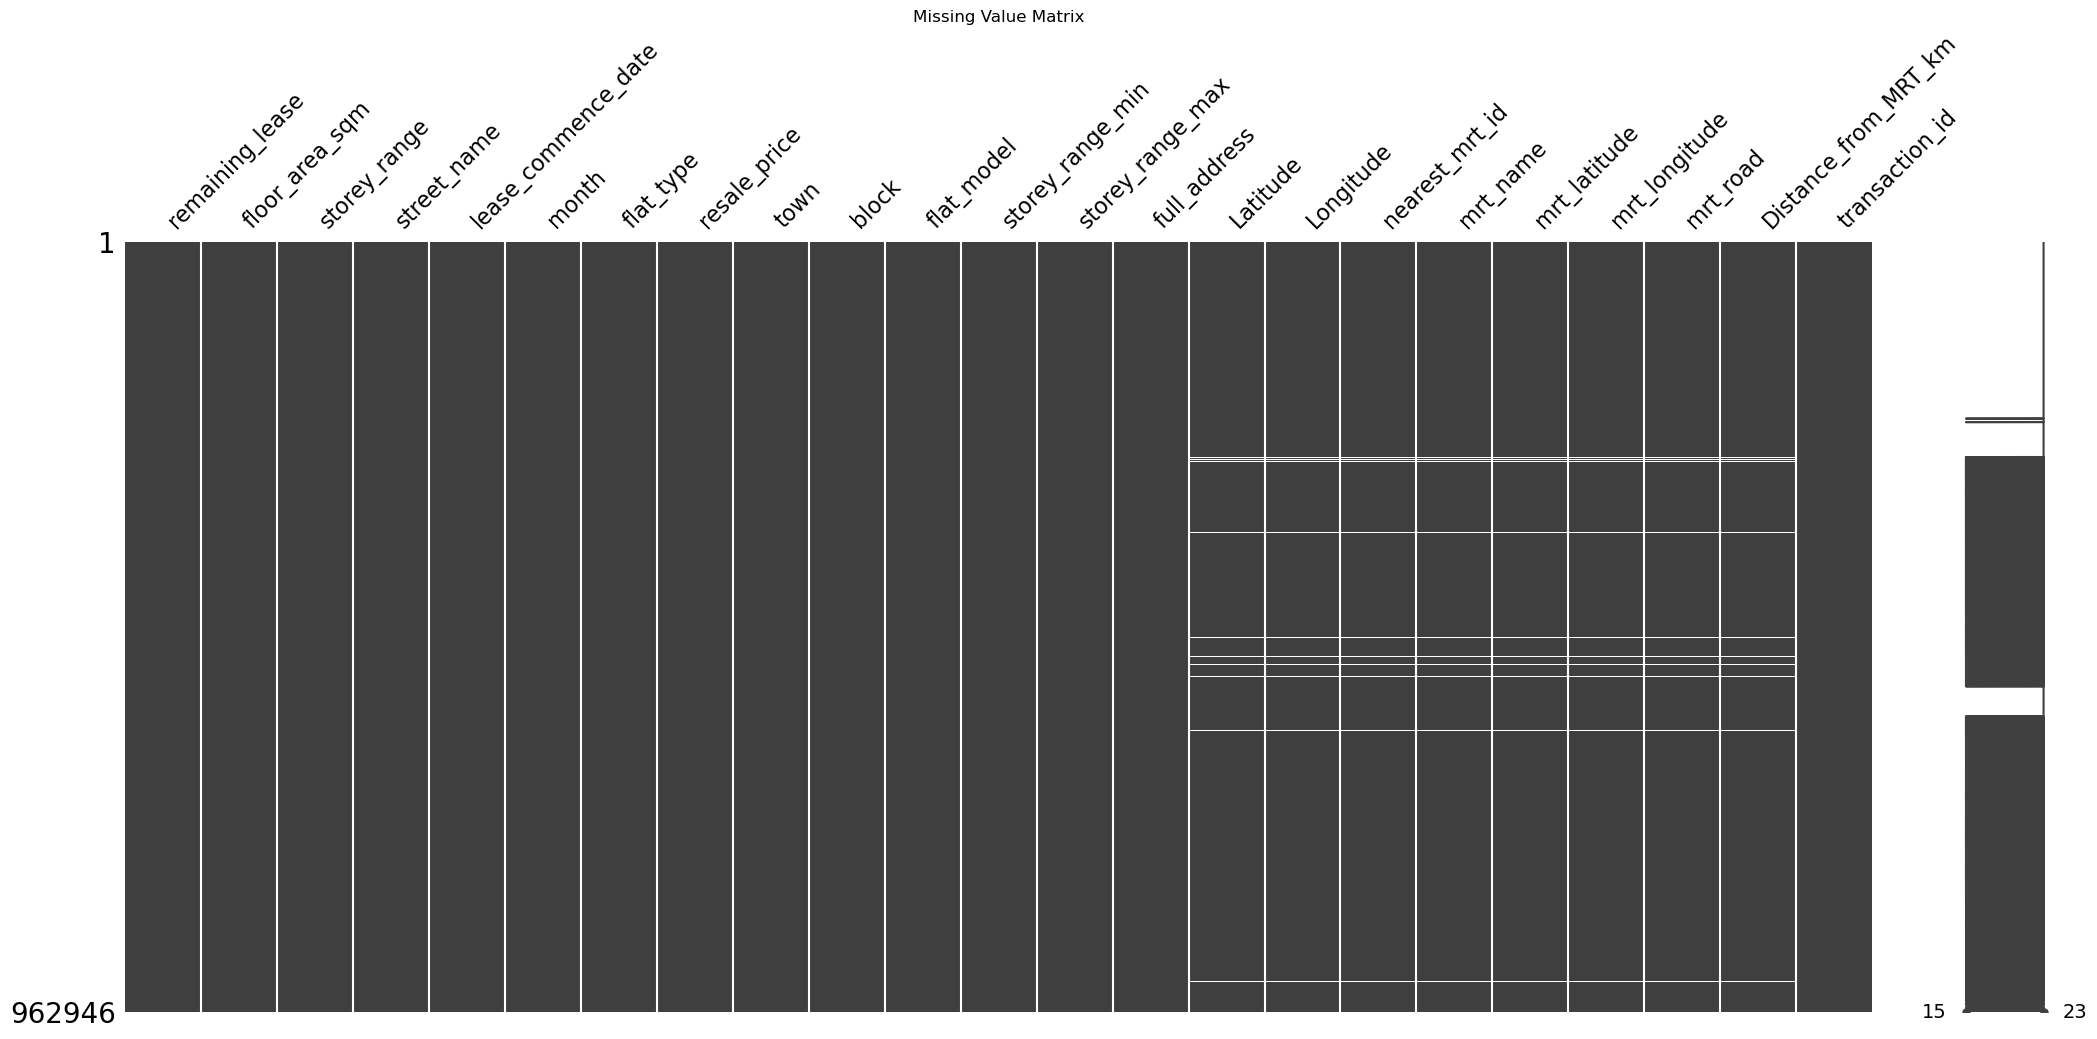

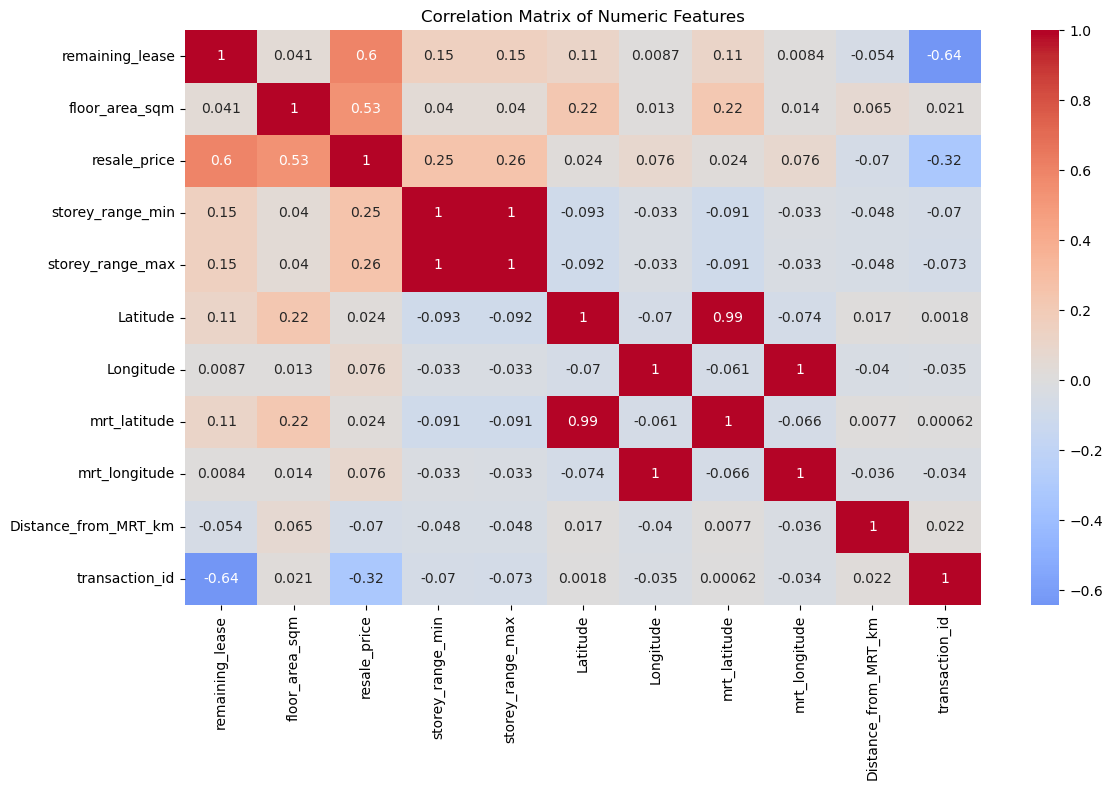

In [3]:
def check_data_quality(df):
    """
    Comprehensive data quality check for DataFrame
    """
    print("=== Data Quality Report ===\n")
    
    # Basic DataFrame Info
    print("1. Basic Information:")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]:,}")
    print("\n2. Data Types:")
    print(df.dtypes)
    
    # Missing Values
    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Values'] > 0])
    
    # Infinite Values
    print("\n4. Infinite Values:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_counts = {col: np.sum(~np.isfinite(df[col])) for col in numeric_cols}
    inf_df = pd.DataFrame.from_dict(inf_counts, orient='index', columns=['Count'])
    print(inf_df[inf_df['Count'] > 0])
    
    # Zero Values (for numeric columns)
    print("\n5. Zero Values (numeric columns):")
    zero_counts = {col: (df[col] == 0).sum() for col in numeric_cols}
    zero_pct = {col: (zero_counts[col] / len(df)) * 100 for col in numeric_cols}
    zeros_df = pd.DataFrame({
        'Zero Count': zero_counts,
        'Zero Percentage': zero_pct
    })
    print(zeros_df[zeros_df['Zero Count'] > 0])
    
    # Unique Values (for categorical columns)
    print("\n6. Unique Values (categorical columns):")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        n_unique = df[col].nunique()
        print(f"{col}: {n_unique:,} unique values")
    
    # Memory Usage
    print("\n7. Memory Usage:")
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # in MB
    print(f"Total Memory Usage: {memory_usage:.2f} MB")

# Run the analysis
check_data_quality(df)

#Visual missing value analysis using missingno
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap for numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

### Filter Data Required for Model

In [4]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    # Ensure month and lease_commence_date are datetime
    df = clean_hdb_df.copy()

    # Drop rows with missing or invalid price
    df = df[df["resale_price"].notnull() & (df["resale_price"] > 0)]

    #date type
    df["month"] = pd.to_datetime(df["month"])
    df["lease_commence_date"] = pd.to_datetime(df["lease_commence_date"], errors='coerce')

    # Features
    feature_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_year": df["month"].dt.year,
        "town": df["town"],
        "flat_type": df["flat_type"],
        "flat_age": ((df["month"] - df["lease_commence_date"]).dt.days / 365.25).clip(lower=0),
    })

    # Targets (log-transform)
    target_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_price": df["resale_price"]
    })

    # Split into past and future
    past_mask = feature_df["resale_year"] <= year_cutoff
    future_mask = feature_df["resale_year"] > year_cutoff

    past_feature_df = feature_df[past_mask].copy()
    future_feature_df = feature_df[future_mask].copy()

    past_target_df = target_df[past_mask].copy()
    future_target_df = target_df[future_mask].copy()

    return past_feature_df, past_target_df, future_feature_df, future_target_df


In [5]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(df, year_cutoff=2013)

Test Train split on past data

In [6]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    past_feature_df, past_target_df, test_size=0.2, random_state=42
)


# One-hot encode categoricals, scale numerics

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [8]:
def preprocess_features_pipeline(feature_df, numeric_features=None, categorical_features=None, preprocessor=None, fit=True):
    df = feature_df.copy()
    if "transaction_id" in df.columns:
        df = df.drop(columns=["transaction_id"])

    if numeric_features is None:
        numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ])

    if fit:
        X_processed = preprocessor.fit_transform(df)
    else:
        X_processed = preprocessor.transform(df)

    return X_processed, preprocessor


In [9]:
categorical_cols = ["town", "flat_type"]
numeric_cols = ["resale_year", "flat_age"]

In [10]:
X_train, preprocessor = preprocess_features_pipeline(X_train_df, numeric_cols, categorical_cols, fit=True)
X_test, _ = preprocess_features_pipeline(X_test_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)
X_future, _ = preprocess_features_pipeline(future_feature_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)


# Modeling

xgboost

In [11]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [12]:
# convert df to np array
y_train = y_train_df["resale_price"].values.astype(float)

In [13]:


xgb_model.fit(X_train,y_train)



,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Predicting with Test Data

In [14]:
y_test_predict=xgb_model.predict(X_test)
y_test = y_test_df["resale_price"].values.astype(float)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
mape = np.mean(np.abs((y_test - y_test_predict) / y_test)) * 100
r2 = r2_score(y_test, y_test_predict)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {r2:.4f}")

if r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 28604.05
Test Mean Absolute Percentage Error: 8.97%
Test R^2 (Coefficient of Determination): 0.9530
Your predictive model is excellent!!


In [15]:
y_test_predict

array([293529.78 , 360626.06 , 128841.586, ..., 132650.9  , 265337.22 ,
       282667.2  ], shape=(138591,), dtype=float32)

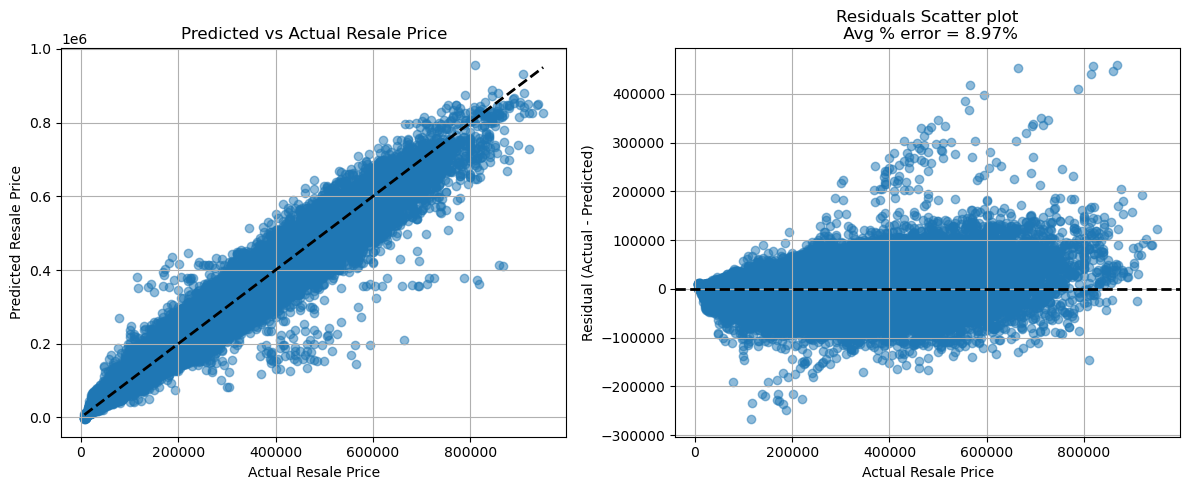

In [16]:
# Scatter plot: predicted vs actual resale prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.grid(True)

# RMSE as residual scatter plot
residuals = y_test - y_test_predict

plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
#plt.ylabel('Percentage Residual (Actual - Predicted)')
#plt.title(f'Residuals Scatter plot\nRMSE = {rmse:.2f}')
plt.title(f'Residuals Scatter plot\n Avg % error = {mape:.2f}%')
plt.grid(True)

plt.tight_layout()
plt.savefig("figures/XGB_test_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()




## Predicting with new data

In [17]:
def predict_resale_price(model, actual_df, flat_type, town, flat_age, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : statsmodels results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
            'transaction_id': [0],  # Dummy ID
            'resale_year': [resale_year],
            'town': [town],
            'flat_age': [flat_age],
            'flat_type': [flat_type]
            })
    print(input_df.shape)
    
    X_input, _ = preprocess_features_pipeline(input_df,
            numeric_features=numeric_cols,
            categorical_features=categorical_cols,
            preprocessor=preprocessor,  # preprocessor fitted during training
            fit=False   
            )
  
    predicted_price = model.predict(X_input)

    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 2) &
        (actual_df['flat_age'] <= flat_age + 2) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${similar_flats['resale_price'].mean():,.2f}")
        print(f"  Price Range: ${similar_flats['resale_price'].min():,.2f} - ${similar_flats['resale_price'].max():,.2f}")
        print(f"  Median: ${similar_flats['resale_price'].median():,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [18]:
predicted_price, similar_flats = predict_resale_price(
    model=xgb_model,
    flat_type='4 ROOM',
    town='BEDOK',
    flat_age=25,
    resale_year=2014,
    actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f} SGD")

(1, 5)

Similar Flats Found: 4
  Average Actual Price: $452,472.00
  Price Range: $400,000.00 - $598,000.00
  Median: $405,944.00

Predicted Resale Price: 442842.94 SGD


# Future Data

### All future data until 2025

In [19]:
y_future_predict=xgb_model.predict(X_future)

y_future_true = future_target_df["resale_price"].values.astype(float)

future_rmse = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_mape = np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100
future_r2 = r2_score(y_future_true, y_future_predict)

print(f"Test RMSE: {future_rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {future_mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {future_r2:.4f}")

if future_r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 115163.65
Test Mean Absolute Percentage Error: 16.96%
Test R^2 (Coefficient of Determination): 0.5845


In [20]:
# Ensure all inputs have the same length
assert len(future_feature_df) == len(future_target_df)  == len(y_future_predict), \
    "All inputs must have the same number of rows"

# Combine the two DataFrames side by side
#final_future_df = pd.concat([future_feature_df.reset_index(drop=True),
#                      future_target_df.reset_index(drop=True)], axis=1)
# Merge the two DataFrames on 'transaction_id'
final_future_df = pd.merge(
    future_feature_df,
    future_target_df,
    on='transaction_id',
    how='inner'   # use 'left', 'right', or 'outer' if needed
)

# Display the combined DataFrame
print(final_future_df.head())


# Add y_test and y_test_predict as new columns
#final_future_df['y_test'] = y_test
final_future_df['y_future_predict'] = y_future_predict

# Display the combined DataFrame
print(final_future_df.head())


   transaction_id  resale_year        town flat_type   flat_age  resale_price
0               1         2017  ANG MO KIO    2 ROOM  38.001369      232000.0
1               2         2017  ANG MO KIO    3 ROOM  39.000684      250000.0
2               3         2017  ANG MO KIO    3 ROOM  37.002053      262000.0
3               4         2017  ANG MO KIO    3 ROOM  37.002053      265000.0
4               5         2017  ANG MO KIO    3 ROOM  37.002053      265000.0
   transaction_id  resale_year        town flat_type   flat_age  resale_price  \
0               1         2017  ANG MO KIO    2 ROOM  38.001369      232000.0   
1               2         2017  ANG MO KIO    3 ROOM  39.000684      250000.0   
2               3         2017  ANG MO KIO    3 ROOM  37.002053      262000.0   
3               4         2017  ANG MO KIO    3 ROOM  37.002053      265000.0   
4               5         2017  ANG MO KIO    3 ROOM  37.002053      265000.0   

   y_future_predict  
0      280735.46875  
1

### prediction for year 2014

In [21]:
future_df_2014= final_future_df[final_future_df['resale_year']==2014]
y_future_true= future_df_2014['resale_price'].values.astype(float)
y_future_predict= future_df_2014['y_future_predict'].values.astype(float)

future_residuals = y_future_true - y_future_predict
future_rmse_values = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_mape_values = np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100
future_r2_values = r2_score(y_future_true, y_future_predict)

print(f"RMSE: ${future_rmse_values:.2f}")
print(f"Mean Absolute Percentage Error: {future_mape_values:.2f}%")
print(f"R^2 (Coefficient of Determination): {future_r2_values:.4f}")

RMSE: $54493.20
Mean Absolute Percentage Error: 10.23%
R^2 (Coefficient of Determination): 0.8034


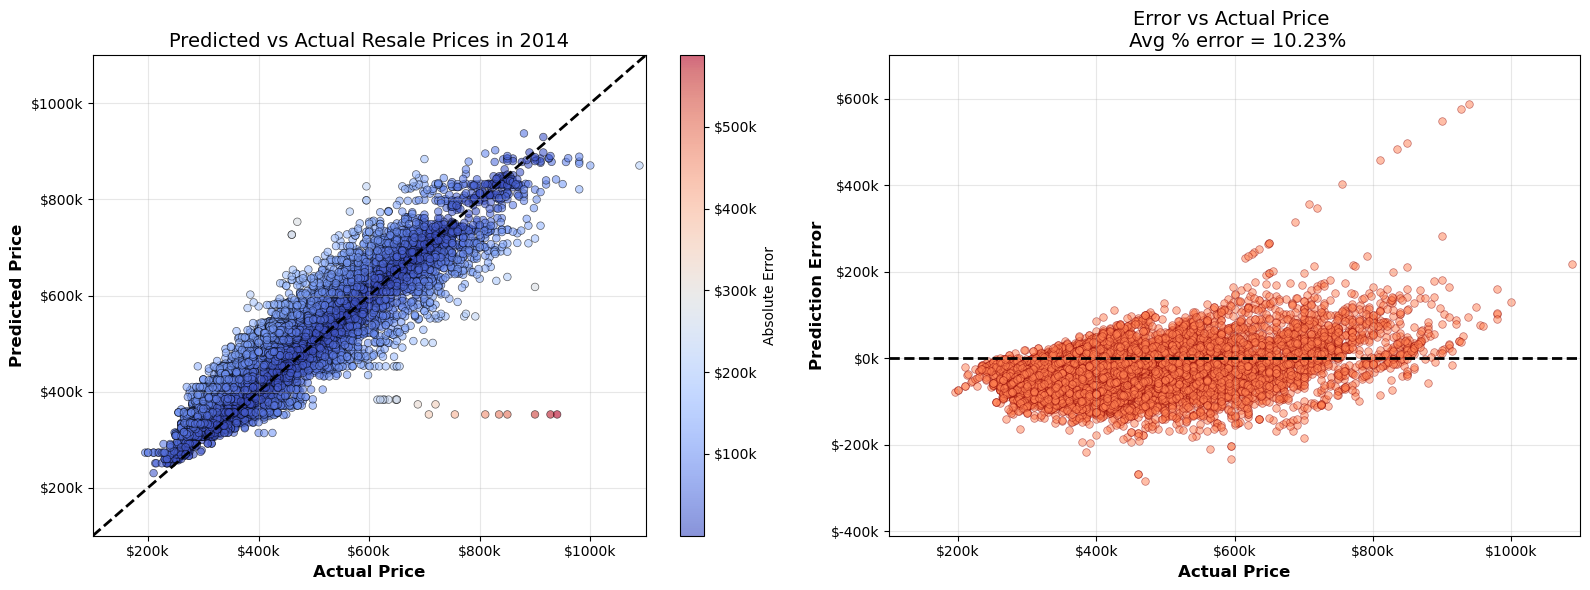

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Predicted vs Actual (color by error) ---
ax = axes[0]
abs_error = np.abs(y_future_true - y_future_predict)
scatter = ax.scatter(
    y_future_true, 
    y_future_predict, 
    c=abs_error,
    cmap='coolwarm',
    alpha=0.6,
    s=30,
    edgecolors='black',
    linewidth=0.5
)
#ax.plot([y_future_true.min(), y_future_true.max()],
#        [y_future_true.min(), y_future_true.max()], 'k--', lw=2)
x = np.linspace(100000, 1100000, 100)
ax.plot(x, x,'k--', linewidth=2, label=None)
ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Price', fontsize=12, fontweight='bold')
ax.set_title('Predicted vs Actual Resale Prices in 2014', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(100000, 1100000)
ax.set_ylim(100000, 1100000)
# Format axes in thousands with dollar sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=10) 
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))

# --- Residuals ---
ax = axes[1]
ax.scatter(y_future_true, future_residuals, alpha=0.5, s=30, c='coral', edgecolors='darkred', linewidth=0.5)
ax.axhline(0, color='k', lw=2, linestyle='--')
ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Error', fontsize=12, fontweight='bold')
#ax.set_title(f'Coefficient of determination \n r2 = {future_r2_values:.2f}', fontsize=14)
ax.set_title(f"Error vs Actual Price \n Avg % error = {future_mape_values:.2f}%", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(-410000, 700000)
ax.set_xlim(100000, 1100000)

# Format axes in thousands with dollar sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

plt.tight_layout()
plt.savefig("figures/XGB_forecast_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()